In [1]:
import copy
import os
import sys

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import vmap
import optax
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.collections as mcoll
import matplotlib.patches as mpatches
params = {'text.usetex': False, 'mathtext.fontset': 'cm'}
plt.rcParams.update(params)

from fbpinns.domains import RectangularDomainND
from fbpinns.networks import FCN
from fbpinns.trainers import get_inputs, FBPINN_model_jit
from fbpinns.analysis import load_model
from fbpinns.util.logger import logger
from fbpinns.util.other import colors
from fbpinns.util.sbatch import apply_config_deltas
from fbpinns.util.jax_util import tree_index

from elm.elms import ELM, ELM_sigmoid, ELM_SIREN
from elm.optimisers import LinearSolver, BlockRRQRLinearSolver, AdditiveSchwarzLinearSolver
from elm.solvers import sps_cg, sps_lsqr
logger.setLevel("CRITICAL")

from problems import HarmonicOscillator1D, HarmonicOscillatorELM1D, Laplace2D_multiscale, LaplaceELM2D_multiscale, WaveEquationConstantVelocity3D, WaveEquationConstantVelocityELM3D
from plot import exact_solution, FBPINN_solution, PINN_solution, compact_sci, make_latex_array, make_latex_tabular
from plot import load_FBPINN as load_FBPINN_
from plot import load_ELMFBPINN as load_ELMFBPINN_
from plot import load_PINN as load_PINN_

def _get_seed_stats(c, model, i, ts, l1ns):
    ts, l1ns = np.stack(ts, axis=1), np.stack(l1ns, axis=1)
    t_mu, t_sd, t_mi, t_ma = ts.mean(axis=1), ts.std(axis=1), ts.min(axis=1), ts.max(axis=1)
    l1_mu, l1_sd, l1_mi, l1_ma, l1_me = l1ns.mean(axis=1), l1ns.std(axis=1), l1ns.min(axis=1), l1ns.max(axis=1), np.median(l1ns, axis=1)
    mi = l1ns.min(axis=0)
    l1_min_me, l1_min_mi, l1_min_ma = np.median(mi), mi.min(), mi.max()
    print(i[-1], l1ns.shape, c.run)
    return c, model, i, (t_mu, t_sd, t_mi, t_ma), (l1_mu, l1_sd, l1_mi, l1_ma, l1_me, l1_min_me, l1_min_mi, l1_min_ma)
    
def load_PINN(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir):
    "Loads PINNs over multiple seeds, and returns average losses / times"
    ts, l1ns = [],[]
    for seed in range(n_seeds):
        c, model, i, t, l1n = load_PINN_(tag, problem, network, h, p, n, lr, seed, rootdir)
        ts.append(t); l1ns.append(l1n)
    return _get_seed_stats(c, model, i, ts, l1ns)
    
def load_FBPINN(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir):
    "Loads FBPINNs over multiple seeds, and returns average losses / times"
    ts, l1ns = [],[]
    for seed in range(n_seeds):
        c, model, i, t, l1n = load_FBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, rootdir)
        ts.append(t); l1ns.append(l1n)
    return _get_seed_stats(c, model, i, ts, l1ns)

def load_ELMFBPINN_info(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir):
    "Loads ELMFBPINNs optimiser info over multiple seeds, and returns average losses / times"
    ts, l1ns = [],[]
    for seed in range(n_seeds):
        c, model, _, _, _ = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)
        info = load_npz(f"{rootdir}summaries/{c.run}/info.npz")
        i, t, l1n = info[1][:,0], info[1][:,1], info[1][:,-1]# [i, time.time()-start0, loss, l1, l1n]
        ts.append(t); l1ns.append(l1n)
    return _get_seed_stats(c, model, i, ts, l1ns)

rootdir = "results/"
run_ELMFBPINN, run_FBPINN, run_PINN = "run_ELMFBPINN", "run_FBPINN", "run_PINN"
loader = {run_PINN: load_PINN,
          run_FBPINN: load_FBPINN,
          run_ELMFBPINN: load_ELMFBPINN_info}

def optimiser_label(optimiser, optimiser_kwargs, run_fn):
    if run_fn == run_PINN:
        label = "PINN-Adam"
        icolor = 5
    elif run_fn == run_FBPINN:
        label = "FBPINN-Adam"
        icolor = 4
    else:
        solver = optimiser_kwargs["solver"]
        solver_labels = {
            sps_cg: "CG",
            sps_lsqr: "LSQR",
        }
        label = \
        {LinearSolver: f"{solver_labels[solver]}",
         BlockRRQRLinearSolver: f"RRQR-{solver_labels[solver]}",
         AdditiveSchwarzLinearSolver: f"AS-{solver_labels[solver]}",
        }[optimiser]
        icolor = {LinearSolver:{sps_lsqr:0, sps_cg:1},
                  BlockRRQRLinearSolver:{sps_lsqr:2},
                  AdditiveSchwarzLinearSolver:{sps_cg:3}}[optimiser][solver]
    return label, icolor

def network_label(network):
    return {FCN:"$\\text{FCN}$",
            ELM:"$\\text{ELM}$",
            ELM_sigmoid:"$\\text{ELM}_{\\sigma}$",
            ELM_SIREN:"$\\text{ELM}_\\text{SIREN}$",
           }[network]

def problem_label(problem):
    return {HarmonicOscillatorELM1D:"Harmonic oscillator in 1D",
            LaplaceELM2D_multiscale:"Multi-scale Laplacian in 2D",
            WaveEquationConstantVelocityELM3D:"Time-varying wave equation in (2+1)D",
           }[problem]

def load_npz(file):
    return (lambda f: [f[k] for k in f.files])(np.load(file))

def plot_l1(i, l1s, label=None, marker=None, color=None, s=None, lw=None):
    _, _, l1_mi, l1_ma, l1_me, _, _, _ = l1s
    plt.plot(i, l1_me, label=label, c=color, lw=lw)
    plt.fill_between(i, l1_mi, l1_ma, lw=0, color=color, alpha=0.2)
    if marker is not None:
        plt.scatter(i[-1], l1_me[-1], marker=marker, edgecolors="none", facecolors=color, s=s)

def scatter_l1(ts, l1s, label=None, marker=None, color=None, s=None, lw=None):
    (t_mu, _, t_mi, t_ma), (_, _, _, _, _, l1_min_me, l1_min_mi, l1_min_ma) = ts, l1s
    plt.errorbar(t_mu[-1], l1_min_me, 
                 xerr=np.array([[t_mu[-1]-t_mi[-1]],[t_ma[-1]-t_mu[-1]]]),
                 yerr=np.array([[l1_min_me-l1_min_mi],[l1_min_ma-l1_min_me]]),
                 ecolor=color,
                 marker=marker,
                 markeredgecolor="none",
                 markerfacecolor=color,
                 label=label,
                 markersize=s,
                 lw=0,
                 elinewidth=lw)

def plot_sparse(A, label, color, markersize=1):
    plt.spy(A, markersize=markersize, color=color)
    plt.gca().set_aspect("equal")
    plt.xticks(np.arange(0, A.shape[1], 50))
    plt.title(label, fontsize="x-large")
    
def plot_svd(cns, labels, labelpad=None):
    for i,((_,svals),label) in enumerate(zip(cns, labels)):
        plt.scatter(range(1, len(svals) + 1), svals[::-1], color=colors[i], marker='o', label=label)
    plt.xlabel("Index (sorted)")
    plt.ylabel("$\\sigma(A)$", fontsize="x-large", rotation=0, labelpad=labelpad)
    plt.yscale("log")
    plt.grid(True)
    plt.legend(fontsize="x-large")
    
def fix_plot_convergence(legend=True):
    if legend:
        plt.legend()
    plt.yscale("log")
    plt.xlabel("Iteration step")
    plt.ylabel("Normalised L1 test accuracy ($e_{L_1}$)")

def fix_plot_scaling(legend=True):
    if legend:
        plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Total time elapsed (s)")
    plt.ylabel("Normalised L1 test accuracy ($e_{L_1}$)")

def fix_plot_2d_solution():
    plt.xlabel("$x_1$", fontsize="x-large")
    plt.ylabel("$x_2$", fontsize="x-large")
    plt.xlim(0,1); plt.ylim(0,1)
    
def fix_plot_2d_solution_blank():
    plt.xticks([]); plt.yticks([])
    plt.xlim(0,1); plt.ylim(0,1)

def savefig(problem, tag2=""):
    plt.savefig(f"plots/{problem.__name__}-{tag2}.pdf", bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")

def savetex(s, problem, tag2=""):
    with open(f"plots/{problem.__name__}-{tag2}.tex", "w") as f:
        f.write(s)
        
inc = np.linspace(0.2,0.95,6)
colors1 = cm.Blues(inc)
colors2 = cm.Oranges(inc)
colors3 = cm.Greens(inc)
colors4 = cm.Reds(inc)
colors5 = cm.Purples(inc)
colorss = [colors1, colors2, colors3, colors4, colors5]

def tc(obj, color):
    COLOR_CODES = {
        "black":   "30",
        "red":     "31",
        "green":   "32",
        "yellow":  "33",
        "blue":    "34",
        "magenta": "35",
        "cyan":    "36",
        "white":   "37",
    }
    
    if color.lower() not in COLOR_CODES:
        raise ValueError(f"Unknown color: {color}")
    
    code = COLOR_CODES[color.lower()]
    return f"\033[{code}m{str(obj)}\033[0m"

def cn(rootdir, c, tag):
    "Compute condition number of sparse matrix"
    outfile = f"{rootdir}summaries/{c.run}/{tag}_svals.npy"
    if os.path.isfile(outfile):# cache
        print(f"Loading cached svals for {tag}")
        svals = np.load(outfile)
    else:
        sparse = sps.load_npz(f"{rootdir}summaries/{c.run}/{tag}.npz")
        print(f"Computing svals for {tag} {sparse.shape}..")
        svals = np.linalg.svd(sparse.toarray(), compute_uv=False)
        np.save(outfile, svals)
    cn = svals[0] / svals[-1]
    return cn, svals

print(colors.l)

['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [2]:
n_seeds = 5
seed = n_seeds

optimisers = [
(optax.adam,
 dict(
    ),
 run_PINN),
(optax.adam,
 dict(
    ),
run_FBPINN),
(LinearSolver,
 dict(system="least-squares",
      solver=sps_lsqr,
      solver_kwargs=dict(atol=0, btol=0, damp=0., conlim=0, iter_lim=10000, force_iter_lim=True),# need to specify iterlim otherwise set based on n
      ),
    run_ELMFBPINN),
(LinearSolver,
 dict(system="normal",
      solver=sps_cg,
      solver_kwargs=dict(rtol=0, atol=0, maxiter=10000),# need to specify maxiter otherwise set based on n
      ),
    run_ELMFBPINN),
(AdditiveSchwarzLinearSolver,
 dict(system="normal",
      solver=sps_cg,
      solver_kwargs=dict(rtol=0, atol=0, maxiter=10000),# need to specify maxiter otherwise set based on n
      ),
    run_ELMFBPINN),
(BlockRRQRLinearSolver,
 dict(system="least-squares",
      solver=sps_lsqr,
      solver_kwargs=dict(atol=0, btol=0, damp=0., conlim=0, iter_lim=10000, force_iter_lim=True),# need to specify iterlim otherwise set based on n
      ),
    run_ELMFBPINN),
]
sigmas = [1e-10, 1e-6, 1e-4, 1e-2]
networks = [ELM_sigmoid, ELM_SIREN]
overlaps = [1.9, 1.3]
weight_scales = [0.125, 0.25, 0.5, 1, 2, 4, 8]

# 1D Harmonic oscillator

In [3]:
depths = [(3, 8), (5, 8)]
p0 = dict(
    optimiser=optimisers[-1],
    sigma=1e-8,
    network=ELM,
    h=1,
    p=8,
    weight_scale=1,
    w0=60,
    w=2.9,
    m=20,
    )

In [4]:
# TABLES

deltas = (
    [dict(optimiser=v) for v in optimisers] +
    [dict(sigma=v) for v in sigmas] +
    [dict(network=v) for v in networks] +
    [dict(h=v1, p=v2) for v1,v2 in depths] +
    [dict(w=v) for v in overlaps]
)
rows = []
for config in apply_config_deltas(p0, deltas):
    (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
    sigma = config["sigma"]
    network = config["network"]
    h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
    w0,w,m = config["w0"], config["w"], config["m"]

    if run_fn == run_ELMFBPINN:
        problem=HarmonicOscillatorELM1D
    else:
        problem=HarmonicOscillator1D
    l = 1
    n = ((p+1)*m,)
    if run_fn != run_ELMFBPINN:
        network = FCN
    if run_fn == run_PINN:
        h,p = 2, 64
    lr = 1e-3
    if run_fn == run_ELMFBPINN:
        tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    else:
        tag = f"main-{w0}-w0_{m}-m"
    
    # load models
    try:
        c, model, i, ts, l1s = loader[run_fn](tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)
    except Exception as e:
        print(tc(e, "red"))
        continue
        
    # get condition number
    if run_fn == run_ELMFBPINN:
        # load save_results run
        _c, *_ = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)
        info = load_npz(f"{rootdir}summaries/{_c.run}/info.npz")
        Mcn = f"{cn(rootdir, _c, "M")[0]:.1e}"
        if optimiser_kwargs["system"]=="normal":
            Acn = f"{cn(rootdir, _c, "A")[0]:.1e}"
        else:
            Acn = "N/A"
        if optimiser == BlockRRQRLinearSolver:
            Qcn = f"{cn(rootdir, _c, "Q")[0]:.1e}"
            drop_pct = f"{info[2]*100:.0f}\\%"
            Mrcn = f"{cn(rootdir, _c, "M_reduced")[0]:.1e}"
        else:
            Qcn = "N/A"
            drop_pct = "N/A"
            Mrcn = "N/A"
        if optimiser == AdditiveSchwarzLinearSolver:
            Pcn = f"{cn(rootdir, _c, "Ainv A")[0]:.1e}"
        else:
            Pcn = "N/A"
    else:
        Mcn = Acn = Qcn = Mrcn = Pcn = drop_pct = "N/A"
    
    # get other entries
    sigma = f"{sigma:.0e}" if optimiser == BlockRRQRLinearSolver else "N/A"
    op_label,_ = optimiser_label(optimiser, optimiser_kwargs, run_fn)
    loss = compact_sci(l1s[-3], l1s[-1]-l1s[-2])# min median +/- sd
    t = compact_sci(ts[0][-1], ts[1][-1])# mean +/- sd
    
    rows.append([network_label(network), (h,p), w,
                 Mcn, Mrcn, Qcn, Acn, Pcn,
                 op_label, f"{sigma} ({drop_pct})", loss, t])

columns = ["Network", "$(h,K)$", "$\\delta$",
           "$\\kappa(M)$", "$\\kappa(\\widehat{M})$", "$\\kappa(\\widehat{M} S^{-1})$", "$\\kappa(M^T M)$", "$\\kappa(A^{-1}_{AS} A)$", 
           "Optimiser", "$\\sigma$ ($\\phi_{jk}$ drop \\%)", "$e_{L_1}$", "Time (s)"]

s = make_latex_tabular(columns, rows)
savetex(s, problem, "table")
print(s)
make_latex_array(columns, rows)

10000.0 (3, 5) PINN_main-60-w0_20-m_HarmonicOscillator1D_FCN_2-layers_64-hidden_180-n_0.001-lr-4
10000.0 (3, 5) FBPINN_main-60-w0_20-m_HarmonicOscillator1D_FCN_1-levels_2.9-overlap_1-layers_8-hidden_180-n_0.001-lr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_LinearSolver-least-squares-sps_lsqr-4
Loading cached svals for M
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_LinearSolver-normal-sps_cg-4
Loading cached svals for M
Loading cached svals for A
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
Loading cached svals for M
Loading cached svals for A
Loading cached svals for Ainv A
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overla

<IPython.core.display.Latex object>

10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_LinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4


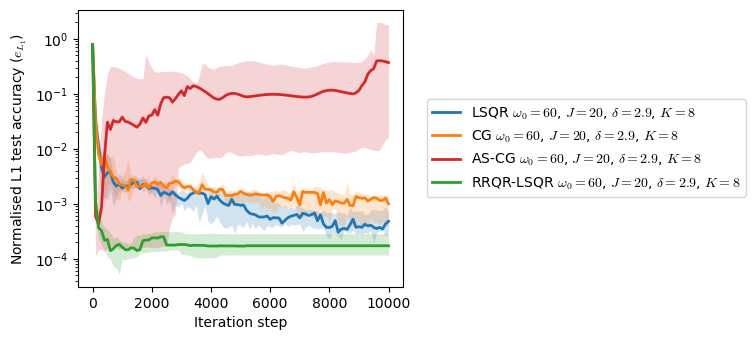

In [5]:
# CONVERGENCE TEST LOSS vs STEP

deltas = (
    [dict(optimiser=v) for v in optimisers[2:]]
)
data = []
for config in apply_config_deltas(p0, deltas):
    (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
    sigma = config["sigma"]
    network = config["network"]
    h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
    w0,w,m = config["w0"], config["w"], config["m"]

    if run_fn == run_ELMFBPINN:
        problem=HarmonicOscillatorELM1D
    else:
        problem=HarmonicOscillator1D
    l = 1
    n = ((p+1)*m,)
    if run_fn != run_ELMFBPINN:
        network = FCN
    if run_fn == run_PINN:
        h,p = 2, 64
    lr = 1e-3
    if run_fn == run_ELMFBPINN:
        tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    else:
        tag = f"main-{w0}-w0_{m}-m"

    # load models
    c, model, i, ts, l1s = load_ELMFBPINN_info(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)

    # get plot entry
    op_label, icolor = optimiser_label(optimiser, optimiser_kwargs, run_fn)
    label = f"{op_label} $\\omega_0={w0}$, $J={m}$, $\\delta={w}$, $K={p}$"
    data.append((label, icolor, i, ts, l1s))

plt.figure(figsize=0.6*np.array([7,6]))
for r, (label, icolor, i, ts, l1s) in enumerate(data):
    plot_l1(i, l1s, label=label, marker=None, color=colors[icolor], s=100, lw=2)
fix_plot_convergence(legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
savefig(problem, "convergence")
plt.show()

10000.0 (101, 5) ELMFBPINN_main-60-w0_10-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_1.45-overlap_1-layers_8-hidden_90-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_40-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_5.8-overlap_1-layers_8-hidden_360-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_80-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_11.6-overlap_1-layers_8-hidden_720-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_160-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_23.2-overlap_1-layers_8-hidden_1440-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_10-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_1.45-overlap_1-layers_8-hidden_90-n_Additive

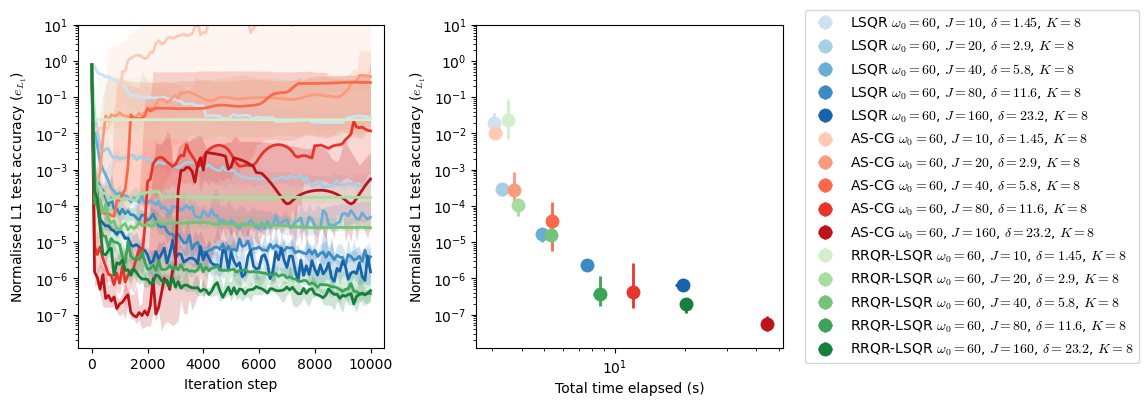

10000.0 (101, 5) ELMFBPINN_main-60-w0_10-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_90-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_40-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_360-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_80-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_720-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_160-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_1440-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_10-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_90-n_AdditiveSchw

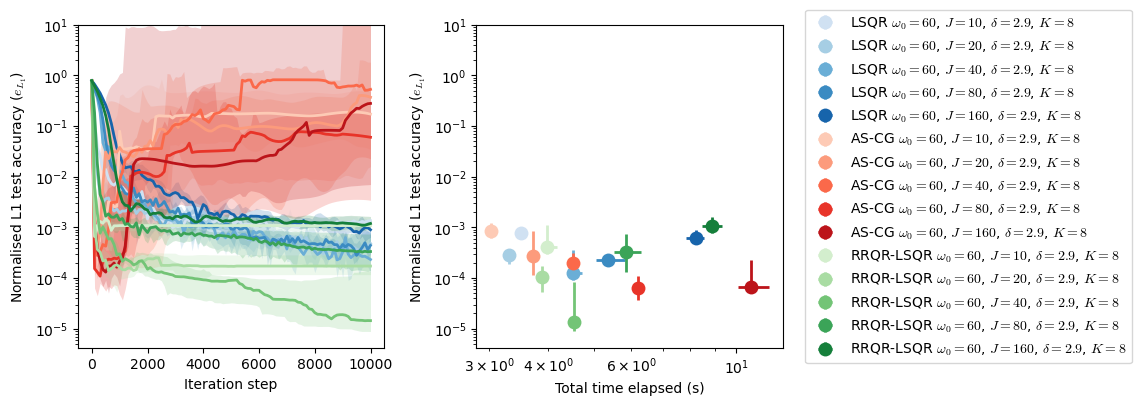

10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_4-hidden_100-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_16-hidden_340-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_32-hidden_660-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_64-hidden_1300-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_4-hidden_100-n_Additive

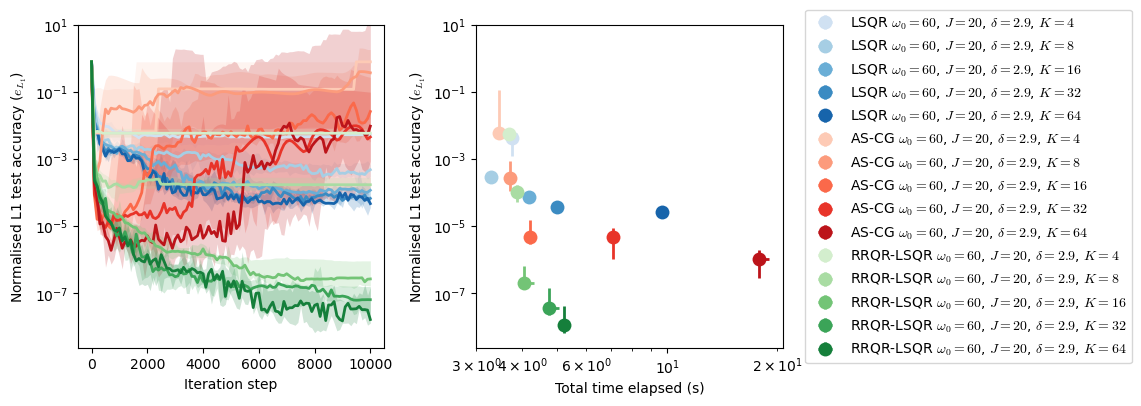

10000.0 (101, 5) ELMFBPINN_main-30-w0_10-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_90-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-120-w0_40-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_360-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-240-w0_80-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_720-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-580-w0_160-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_1440-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-30-w0_10-m_sigma-1e-08_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_90-n_AdditiveS

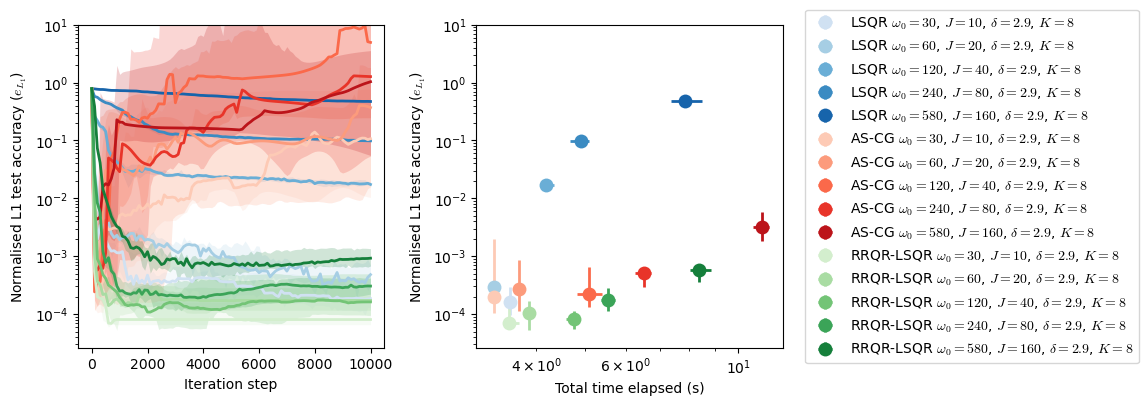

In [6]:
# FINAL TEST LOSS vs TIME (scaling)


# accuracy vs time [w0,overlap,dd,optimiser] (strong scaling & weak scaling) (weak scaling has solution plot from our solver)

for iw_deltas,tag2 in zip(
(
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (60, 2.9*0.5, 10, 8),# strong, w-m
        (60, 2.9*1, 20, 8),
        (60, 2.9*2, 40, 8),
        (60, 2.9*4, 80, 8),
        (60, 2.9*8, 160, 8),
       ])]
    ),
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (60, 2.9, 10, 8),# strong, m
        (60, 2.9, 20, 8),
        (60, 2.9, 40, 8),
        (60, 2.9, 80, 8),
        (60, 2.9, 160, 8),
       ])]
    ),
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (60, 2.9, 20, 4),# strong, p
        (60, 2.9, 20, 8),
        (60, 2.9, 20, 16),
        (60, 2.9, 20, 32),
        (60, 2.9, 20, 64),
       ])]
    ),
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (30, 2.9, 10, 8),# weak, m
        (60, 2.9, 20, 8),
        (120, 2.9, 40, 8),
        (240, 2.9, 80, 8),
        (580, 2.9, 160, 8),
       ])]
    ),
),
    ["strong-wm", "strong-m", "strong-p", "weak"]):
    
    iws, deltas = zip(*iw_deltas)
    data = []
    for iw,config in zip(iws, apply_config_deltas(p0, deltas)):
        (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
        sigma = config["sigma"]
        network = config["network"]
        h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
        w0,w,m = config["w0"], config["w"], config["m"]
    
        if run_fn == run_ELMFBPINN:
            problem=HarmonicOscillatorELM1D
        else:
            problem=HarmonicOscillator1D
        l = 1
        n = ((p+1)*m,)
        if run_fn != run_ELMFBPINN:
            network = FCN
        if run_fn == run_PINN:
            h,p = 2, 64
        lr = 1e-3
        if run_fn == run_ELMFBPINN:
            tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
        else:
            tag = f"main-{w0}-w0_{m}-m"
    
        # load models
        try:
            c, model, i, ts, l1s = load_ELMFBPINN_info(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)
        except Exception as e:
            print(tc(e, "red"))
            continue
            
        # get plot entry
        op_label, icolor = optimiser_label(optimiser, optimiser_kwargs, run_fn)
        label = f"{op_label} $\\omega_0={w0}$, $J={m}$, $\\delta={w}$, $K={p}$"
        data.append((label, icolor, iw, i, ts, l1s))
    
    
    plt.figure(figsize=0.7*np.array([13,6]))
    
    plt.subplot(1,2,1)
    for label, icolor, iw, i, ts, l1s in data:
        plot_l1(i, l1s, label=label, marker=None, color=colorss[icolor][iw], s=100, lw=2)
    fix_plot_convergence(legend=False)
    ylim = plt.ylim()
    mi = min([d[5][2].min() for d in data])# min l1n mi
    ylim=(max(mi/3,ylim[0]),min(ylim[1], 1e1))
    plt.ylim(ylim)
    
    plt.subplot(1,2,2)
    for label, icolor, iw, i, ts, l1s in data:
        scatter_l1(ts, l1s, label=label, marker="o", color=colorss[icolor][iw], s=10, lw=2)
    fix_plot_scaling()
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.ylim(ylim)
    
    plt.subplots_adjust(wspace=0.3)
    savefig(problem, f"{tag2}-scaling")
    plt.show()

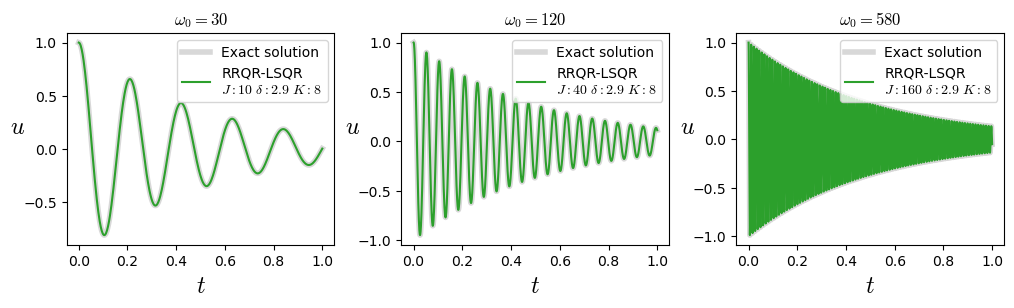

In [7]:
# WEAK SCALING COMPARISON

deltas = [dict(w0=v1, w=v2, m=v3, p=v4) for v1,v2,v3,v4 in [
        (30, 2.9, 10, 8),# weak, m
        #(60, 2.9, 20, 8),
        (120, 2.9, 40, 8),
        #(240, 2.9, 80, 8),
        (580, 2.9, 160, 8),
]]
data = []
for config in apply_config_deltas(p0, deltas):
    (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
    sigma = config["sigma"]
    network = config["network"]
    h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
    w0,w,m = config["w0"], config["w"], config["m"]

    tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    problem=HarmonicOscillatorELM1D
    l=1
    n = ((p+1)*m,)
    lr=1e-3
    
    c, model, i, t, l1n = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)

    # get exact solution
    u_exact = exact_solution(c, model)
    u = FBPINN_solution(c, model)
    t = np.linspace(0,1,u_exact.shape[0])
    
    # get plot entry
    op_label, icolor = optimiser_label(optimiser, optimiser_kwargs, run_fn)
    label = f"{op_label}\n$J:{m}$ $\\delta:{w}$ $K:{p}$"

    data.append([w0, u_exact, u, t, label, icolor])


# plot

plt.figure(figsize=0.55*np.array([22,5]))

for i,(w0, u_exact, u, t, label, icolor) in enumerate(data[:-1]):
    plt.subplot(1,3,1+i)
    plt.title(f"$\\omega_0={w0}$")
    plt.plot(t, u_exact, label="Exact solution", lw=4, color="tab:grey", alpha=0.3)
    plt.plot(t, u, label=label, lw=1.5, color=colors[icolor])
    plt.xlabel("$t$", fontsize="xx-large")
    plt.ylabel("$u$", fontsize="xx-large", rotation=0)
    plt.legend()

plt.subplots_adjust(wspace=0.25)
savefig(problem, "weak-solution")
plt.show()

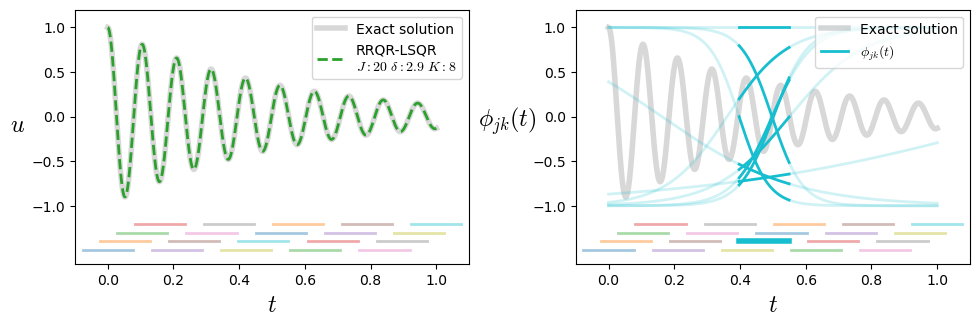

Loading cached svals for M
Loading cached svals for Q


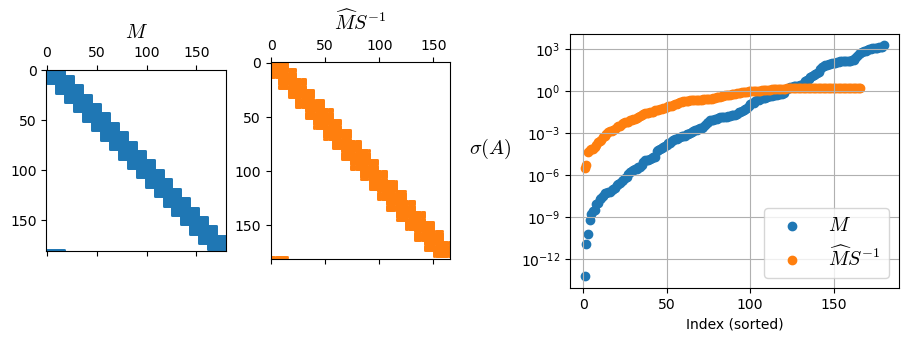

In [8]:
# BASE CASE PLOTS

(optimiser,optimiser_kwargs,run_fn) = p0["optimiser"]
sigma = p0["sigma"]
network = p0["network"]
h,p,weight_scale = p0["h"], p0["p"], p0["weight_scale"]
w0,w,m = p0["w0"], p0["w"], p0["m"]

tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
problem=HarmonicOscillatorELM1D
l=1
n = ((p+1)*m,)
n_test = (50*m,)
lr=1e-3

c, model, i, t, l1n = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)
op_label, _ = optimiser_label(optimiser, optimiser_kwargs, run_fn)
label = f"{op_label}\n$J:{m}$ $\\delta:{w}$ $K:{p}$"

# get exact solution
u_exact = exact_solution(c, model)
u = FBPINN_solution(c, model)
t = np.linspace(0,1,u_exact.shape[0])

# get basis functions
all_params = model[1]
x = t.reshape(n_test+(1,))
domain, problem, decomposition = c.domain, c.problem, c.decomposition
def basis_fn(all_params, x, norm_fn, window_fn):
    w = window_fn(all_params, x)
    x = norm_fn(all_params, x)
    x = c.network.basis_fn(all_params, x)
    return x
d = all_params
f = {t_k: {cl_k: {k: jax.tree_util.tree_map(lambda p: 0, d[t_k][cl_k][k]) if k=="subdomain" else jax.tree_util.tree_map(lambda p: None, d[t_k][cl_k][k])
    for k in d[t_k][cl_k]}
    for cl_k in d[t_k]}
    for t_k in ["static", "trainable"]}
b = jax.vmap(jax.vmap(basis_fn, in_axes=(f,None,None,None)), in_axes=(None, 0, None, None))(
    all_params, x, decomposition.norm_fn, decomposition.window_fn)# (N, J, C)

# get domain decomposition
xs = c.decomposition_init_kwargs["subdomain_xss"][0][0]
ws = c.decomposition_init_kwargs["subdomain_wss"][0][0]


# PLOT solution & DD
plt.figure(figsize=0.55*np.array([21,6]))

plt.subplot(1,2,1)
plt.plot(t, u_exact, color="tab:grey", lw=4, alpha=0.3, label="Exact solution")
plt.plot(t, u, "--", color="tab:green", lw=2, label=label)

for j,(x_, w_) in enumerate(zip(xs, ws)):
    plt.plot([x_-(w_/2), x_+(w_/2)], [(j%4)/10 - 1.5, (j%4)/10 - 1.5],
            lw=2, alpha=0.4, color=colors[j])
plt.xlabel("$t$", fontsize="xx-large")
plt.ylabel("$u$", fontsize="xx-large", rotation=0, labelpad=10)

plt.xlim(-0.1, 1.1)
plt.ylim(-1.65,1.2)
plt.yticks([-1,-0.5,0,0.5,1])
plt.legend()

# PLOT basis & DD

plt.subplot(1,2,2)
plt.plot(t, u_exact, color="tab:grey", lw=4, alpha=0.3, label="Exact solution")

for j,(x_, w_) in enumerate(zip(xs, ws)):
    plt.plot([x_-(w_/2), x_+(w_/2)], [(j%4)/10 - 1.5, (j%4)/10 - 1.5],
            lw=(4 if j==9 else 2), alpha = (1 if j==9 else 0.4), color=colors[j])
plt.xlabel("$t$", fontsize="xx-large")
plt.ylabel("$\\phi_{jk}(t)$", fontsize="xx-large", rotation=0, labelpad=18)

j = 9
for k in range(b.shape[2]):
    fl = (x < (xs-ws/2)[j])[:,0]
    fm = ((x >= (xs-ws/2)[j]) & (x <= (xs+ws/2)[j]))[:,0]
    fr = (x > (xs+ws/2)[j])[:,0]
    plt.plot(x[fl], b[fl,j,k], color=colors[j], alpha=0.2, lw=2)
    plt.plot(x[fm], b[fm,j,k], color=colors[j], lw=2, label="$\\phi_{jk}(t)$" if k == 0 else None)
    plt.plot(x[fr], b[fr,j,k], color=colors[j], alpha=0.2, lw=2)
plt.xlim(-0.1, 1.1)
plt.ylim(-1.65,1.2)
plt.yticks([-1,-0.5,0,0.5,1])
plt.legend(loc="upper right")

plt.subplots_adjust(wspace=0.27)
savefig(problem, "solution-basis")
plt.show()



# PLOT spectra and sparse matrix
M = sps.load_npz(f"{rootdir}/summaries/{c.run}/M.npz")
Q = sps.load_npz(f"{rootdir}/summaries/{c.run}/Q.npz")

plt.figure(figsize=0.55*np.array([20,6]))

plt.subplot2grid((1,12), (0,0), colspan=3)
plot_sparse(M, "$M$", colors[0])
plt.subplot2grid((1,12), (0,3), colspan=3)
plot_sparse(Q, "$\\widehat{M} S^{-1}$", colors[1])
plt.subplot2grid((1,12), (0,7), colspan=5)
plot_svd([cn(rootdir, c, "M"),cn(rootdir, c, "Q")], 
         ["$M$","$\\widehat{M} S^{-1}$"],
         labelpad=22)

plt.subplots_adjust(wspace=1.5)
savefig(problem, "condition")
plt.show()

# 1D Harmonic oscillator appendix

10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-0_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_1.45-overlap_1-layers_8-hidden_2000-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4
Loading cached svals for M
Loading cached svals for Q
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-0_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_2000-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4
Loading cached svals for M
Loading cached svals for Q
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-0_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_5.8-overlap_1-layers_8-hidden_2000-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4
Loading cached svals for M
Loading cached svals for Q
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-0_ws-1_HarmonicOscillatorELM1D_ELM_1-levels_11.6-overlap_1-layers_8-hidden_2000-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4
Loading cached svals for M
Loading cached svals for Q
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-0_ws-1_HarmonicOscillator

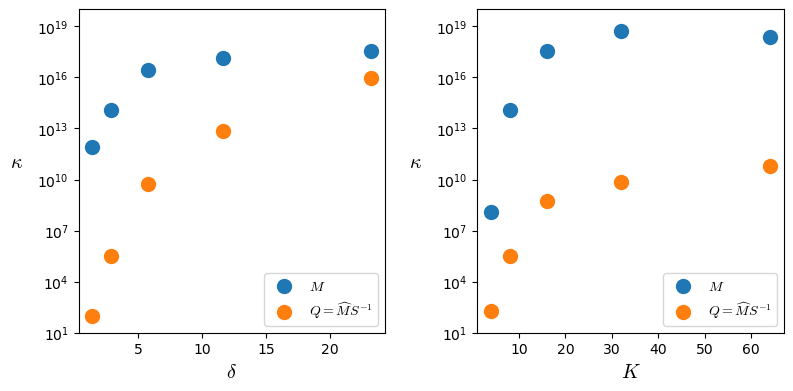

In [9]:
# APPENDIX PLOT

p0 = dict(
    optimiser=optimisers[-1],
    sigma=0,
    network=ELM,
    h=1,
    p=8,
    weight_scale=1,
    w0=60,
    w=2.9,
    m=20,
    )
plt.figure(figsize=0.7*np.array([13,6]))
for iw_deltas,tag2 in zip(
    (
    [(iw, dict(w=v1, p=v2)) for iw,(v1,v2) in enumerate([
        (2.9*0.5, 8),# delta-varying
        (2.9*1, 8),
        (2.9*2, 8),
        (2.9*4, 8),
        (2.9*8, 8),
    ])],

    [(iw, dict(w=v1, p=v2)) for iw,(v1,v2) in enumerate([
        (2.9*1, 4),# channel-varying
        (2.9*1, 8),
        (2.9*1, 16),
        (2.9*1, 32),
        (2.9*1, 64),
       ])],
    ),
    ["appendix-w", "appendix-p"],
):

    iws, deltas = zip(*iw_deltas)
    data = []
    for iw,config in zip(iws, apply_config_deltas(p0, deltas)):
        (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
        sigma = config["sigma"]
        network = config["network"]
        h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
        w0,w,m = config["w0"], config["w"], config["m"]
    
        if run_fn == run_ELMFBPINN:
            problem=HarmonicOscillatorELM1D
        else:
            problem=HarmonicOscillator1D
        l = 1
        
        n = ((100)*m,)
        
        if run_fn != run_ELMFBPINN:
            network = FCN
        if run_fn == run_PINN:
            h,p = 2, 64
        lr = 1e-3
        if run_fn == run_ELMFBPINN:
            tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
        else:
            tag = f"main-{w0}-w0_{m}-m"
    
        # load models
        try:
            c, model, i, ts, l1s = load_ELMFBPINN_info(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)
        except Exception as e:
            print(tc(e, "red"))
            continue

        # load save_results run
        _c, *_ = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)
        Mcn = cn(rootdir, _c, "M")[0]
        Qcn = cn(rootdir, _c, "Q")[0]
        
        # get plot entry
        xlabel="$\\delta$" if tag2=="appendix-w" else "$K$"
        x = w if tag2=="appendix-w" else p
        ip = 1 if tag2=="appendix-w" else 2
        data.append((i, ts, l1s, iw, x, xlabel, Mcn, Qcn, ip))
    
    for i, ts, l1s, iw, x, xlabel, Mcn, Qcn, ip in data:
        plt.subplot(1,2,ip)
        plt.scatter(x, Mcn, s=100, color="tab:blue", label="$M$" if iw==0 else None)
        plt.ylabel("$\\kappa$", rotation=0, fontsize="x-large", labelpad=15)
        plt.xlabel(xlabel, fontsize="x-large")
        plt.yscale("log")
        plt.ylim(1e1, 1e20)

        plt.scatter(x, Qcn, s=100, color="tab:orange", label="$Q=\\widehat{M} S^{-1}$" if iw==0 else None)
        plt.ylabel("$\\kappa$", rotation=0, fontsize="x-large", labelpad=15)
        plt.xlabel(xlabel, fontsize="x-large")
        plt.yscale("log")
        plt.ylim(1e1, 1e20)

plt.subplot(1,2,1)
plt.legend(loc="lower right")
plt.subplot(1,2,2)
plt.legend(loc="lower right")
plt.subplots_adjust(wspace=0.3)
savefig(problem, "appendix-scaling")
plt.show()

# 2D Multiscale Laplace

In [10]:
depths = [(3, 16), (5, 16)]
p0 = dict(
    optimiser=optimisers[-1],
    sigma=1e-8,
    network=ELM,
    h=1,
    p=16,
    weight_scale=1,
    w0=3,
    w=2.9,
    m=16,# m = omegas
    )

In [11]:
# TABLES

deltas = (
    [dict(optimiser=v) for v in optimisers] +
    [dict(sigma=v) for v in sigmas] +
    [dict(network=v) for v in networks] +
    [dict(h=v1, p=v2) for v1,v2 in depths] +
    [dict(w=v) for v in overlaps]
)
rows = []
for config in apply_config_deltas(p0, deltas):
    (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
    sigma = config["sigma"]
    network = config["network"]
    h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
    w0,w,m = config["w0"], config["w"], config["m"]

    if run_fn == run_ELMFBPINN:
        problem=LaplaceELM2D_multiscale
    else:
        problem=Laplace2D_multiscale
    l = 1
    n = (int(np.ceil(np.sqrt((p+1))))*m, int(np.ceil(np.sqrt((p+1))))*m)
    if run_fn != run_ELMFBPINN:
        network = FCN
    if run_fn == run_PINN:
        h,p = 2, 128
    lr = 1e-3
    if run_fn == run_ELMFBPINN:
        tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    else:
        tag = f"main-{w0}-w0_{m}-m"
    
    # load models
    try:
        c, model, i, ts, l1s = loader[run_fn](tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)
    except Exception as e:
        print(tc(e, "red"))
        continue
        
    # get condition number
    if run_fn == run_ELMFBPINN:
        # load save_results run
        _c, *_ = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)
        info = load_npz(f"{rootdir}summaries/{_c.run}/info.npz")
        Mcn = f"{cn(rootdir, _c, "M")[0]:.1e}"
        if optimiser_kwargs["system"]=="normal":
            Acn = f"{cn(rootdir, _c, "A")[0]:.1e}"
        else:
            Acn = "N/A"
        if optimiser == BlockRRQRLinearSolver:
            Qcn = f"{cn(rootdir, _c, "Q")[0]:.1e}"
            drop_pct = f"{info[2]*100:.0f}\\%"
            Mrcn = f"{cn(rootdir, _c, "M_reduced")[0]:.1e}"
        else:
            Qcn = "N/A"
            drop_pct = "N/A"
            Mrcn = "N/A"
        if optimiser == AdditiveSchwarzLinearSolver:
            Pcn = f"{cn(rootdir, _c, "Ainv A")[0]:.1e}"
        else:
            Pcn = "N/A"
    else:
        Mcn = Acn = Qcn = Mrcn = Pcn = drop_pct = "N/A"
    
    # get other entries
    sigma = f"{sigma:.0e}" if optimiser == BlockRRQRLinearSolver else "N/A"
    op_label,_ = optimiser_label(optimiser, optimiser_kwargs, run_fn)
    loss = compact_sci(l1s[-3], l1s[-1]-l1s[-2])# min median +/- sd
    t = compact_sci(ts[0][-1], ts[1][-1])# mean +/- sd
    
    rows.append([network_label(network), (h,p), w,
                 Mcn, Mrcn, Qcn, Acn, Pcn,
                 op_label, f"{sigma} ({drop_pct})", loss, t])

columns = ["Network", "$(h,K)$", "$\\delta$",
           "$\\kappa(M)$", "$\\kappa(\\widehat{M})$", "$\\kappa(\\widehat{M} S^{-1})$", "$\\kappa(M^T M)$", "$\\kappa(A^{-1}_{AS} A)$", 
           "Optimiser", "$\\sigma$ ($\\phi_{jk}$ drop \\%)", "$e_{L_1}$", "Time (s)"]

s = make_latex_tabular(columns, rows)
savetex(s, problem, "table")
print(s)
make_latex_array(columns, rows)

10000.0 (3, 5) PINN_main-3-w0_16-m_Laplace2D_multiscale_FCN_2-layers_128-hidden_80-n_0.001-lr-4
10000.0 (3, 5) FBPINN_main-3-w0_16-m_Laplace2D_multiscale_FCN_1-levels_2.9-overlap_1-layers_16-hidden_80-n_0.001-lr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_LinearSolver-least-squares-sps_lsqr-4
Loading cached svals for M
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_LinearSolver-normal-sps_cg-4
Loading cached svals for M
Loading cached svals for A
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
Loading cached svals for M
Loading cached svals for A
Loading cached svals for Ainv A
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-la

<IPython.core.display.Latex object>

10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_LinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4


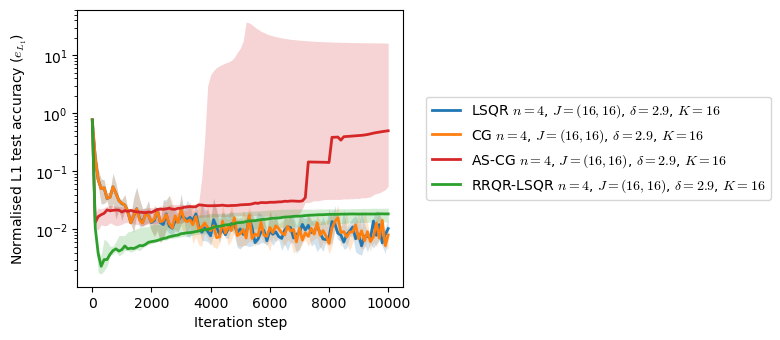

In [12]:
# CONVERGENCE TEST LOSS vs STEP

deltas = (
    [dict(optimiser=v) for v in optimisers[2:]]
)
data = []
for config in apply_config_deltas(p0, deltas):
    (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
    sigma = config["sigma"]
    network = config["network"]
    h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
    w0,w,m = config["w0"], config["w"], config["m"]

    if run_fn == run_ELMFBPINN:
        problem=LaplaceELM2D_multiscale
    else:
        problem=Laplace2D_multiscale
    l = 1
    n = (int(np.ceil(np.sqrt((p+1))))*m, int(np.ceil(np.sqrt((p+1))))*m)
    if run_fn != run_ELMFBPINN:
        network = FCN
    if run_fn == run_PINN:
        h,p = 2, 128
    lr = 1e-3
    if run_fn == run_ELMFBPINN:
        tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    else:
        tag = f"main-{w0}-w0_{m}-m"

    # load models
    c, model, i, ts, l1s = load_ELMFBPINN_info(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)

    # get plot entry
    op_label, icolor = optimiser_label(optimiser, optimiser_kwargs, run_fn)
    label = f"{op_label} $n={w0+1}$, $J={(m,m)}$, $\\delta={w}$, $K={p}$"
    data.append((label, icolor, i, ts, l1s))

plt.figure(figsize=0.6*np.array([7,6]))
for r, (label, icolor, i, ts, l1s) in enumerate(data):
    plot_l1(i, l1s, label=label, marker=None, color=colors[icolor], s=100, lw=2)
fix_plot_convergence(legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
savefig(problem, "convergence")
plt.show()

10000.0 (101, 5) ELMFBPINN_main-3-w0_8-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_1.45-overlap_1-layers_16-hidden_40-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_32-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_5.8-overlap_1-layers_16-hidden_160-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_8-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_1.45-overlap_1-layers_16-hidden_40-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
Model dir empty for run ELMFBPINN_main-3-w0_32-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_5.8-overlap_1-layers_16-hidden_160

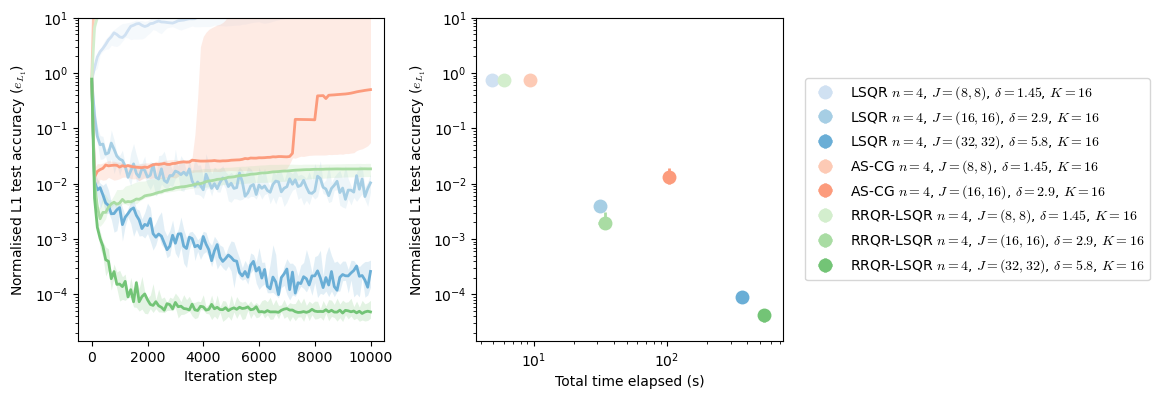

10000.0 (101, 5) ELMFBPINN_main-3-w0_4-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_20-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_8-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_40-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_32-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_160-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_64-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_320-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_4-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_20-n_AdditiveSchwarzLine

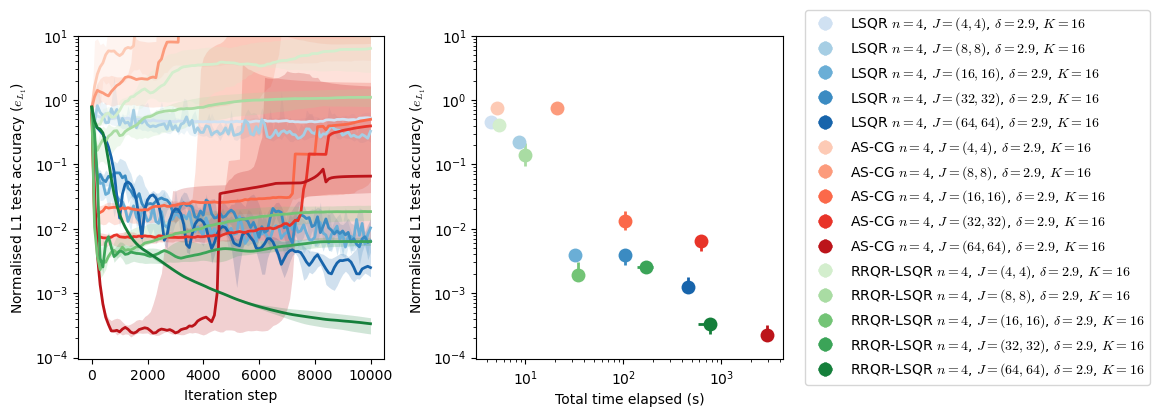

10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_4-hidden_48-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_8-hidden_48-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_32-hidden_96-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_64-hidden_144-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_4-hidden_48-n_AdditiveSchwarzLinea

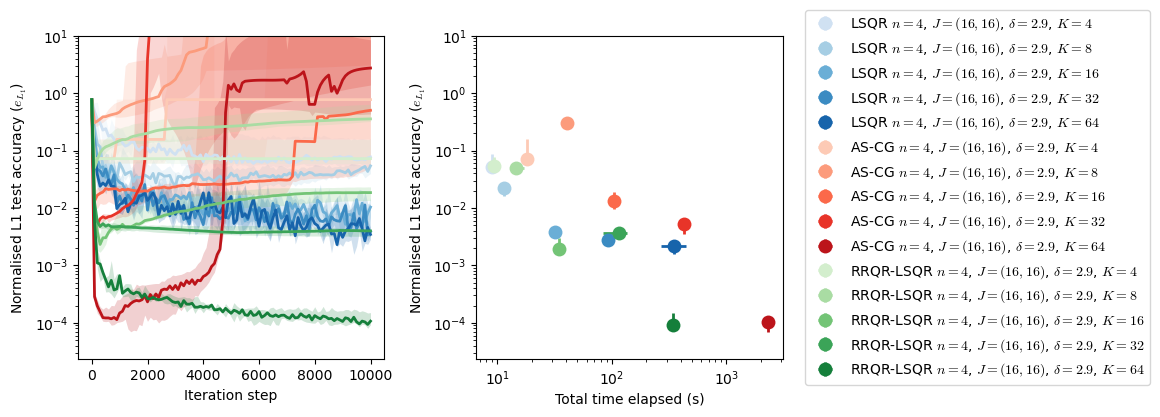

10000.0 (101, 5) ELMFBPINN_main-0-w0_2-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_10-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-1-w0_4-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_20-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-2-w0_8-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_40-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-3-w0_16-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_80-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-4-w0_32-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_160-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-5-w0_64-m_sigma-1e-08_ws-1_LaplaceELM2D_multiscale_ELM_1-levels_2.9-overlap_1-layers_16-hidden_320-n_LinearSolver-least-

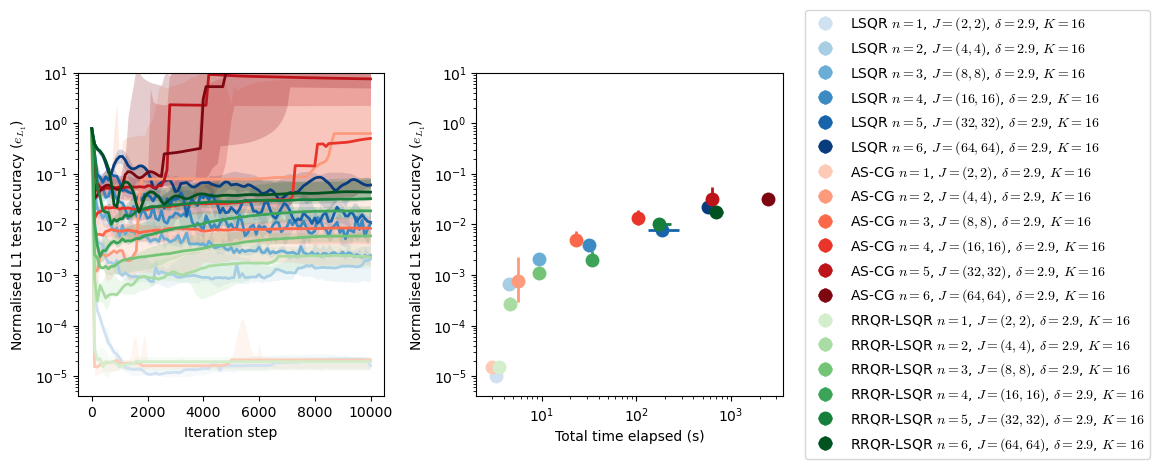

In [13]:
# FINAL TEST LOSS vs TIME (scaling)


# accuracy vs time [w0,overlap,dd,optimiser] (strong scaling & weak scaling) (weak scaling has solution plot from our solver)

for iw_deltas,tag2 in zip(
(
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (3, 2.9*0.5, 8, 16),# strong, w-m
        (3, 2.9*1, 16, 16),
        (3, 2.9*2, 32, 16),
       ])]
    ),
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (3, 2.9, 4, 16),# strong, m
        (3, 2.9, 8, 16),
        (3, 2.9, 16, 16),
        (3, 2.9, 32, 16),
        (3, 2.9, 64, 16),
       ])]
    ),
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (3, 2.9, 16, 4),# strong, p
        (3, 2.9, 16, 8),
        (3, 2.9, 16, 16),
        (3, 2.9, 16, 32),
        (3, 2.9, 16, 64),
       ])]
    ),
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (0, 2.9, 2, 16),# weak, m
        (1, 2.9, 4, 16),
        (2, 2.9, 8, 16),
        (3, 2.9, 16, 16),
        (4, 2.9, 32, 16),
        (5, 2.9, 64, 16),
       ])]
    ),
),
    ["strong-wm", "strong-m", "strong-p", "weak"]):
    
    iws, deltas = zip(*iw_deltas)
    data = []
    for iw,config in zip(iws, apply_config_deltas(p0, deltas)):
        (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
        sigma = config["sigma"]
        network = config["network"]
        h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
        w0,w,m = config["w0"], config["w"], config["m"]
    
        if run_fn == run_ELMFBPINN:
            problem=LaplaceELM2D_multiscale
        else:
            problem=Laplace2D_multiscale
        l = 1
        n = (int(np.ceil(np.sqrt((p+1))))*m, int(np.ceil(np.sqrt((p+1))))*m)
        if run_fn != run_ELMFBPINN:
            network = FCN
        if run_fn == run_PINN:
            h,p = 2, 128
        lr = 1e-3
        if run_fn == run_ELMFBPINN:
            tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
        else:
            tag = f"main-{w0}-w0_{m}-m"
    
        # load models
        try:
            c, model, i, ts, l1s = load_ELMFBPINN_info(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)
        except Exception as e:
            print(tc(e, "red"))
            continue
            
        # get plot entry
        op_label, icolor = optimiser_label(optimiser, optimiser_kwargs, run_fn)
        label = f"{op_label} $n={w0+1}$, $J={(m,m)}$, $\\delta={w}$, $K={p}$"
        data.append((label, icolor, iw, i, ts, l1s))
    
    
    plt.figure(figsize=0.7*np.array([13,6]))
    
    plt.subplot(1,2,1)
    for label, icolor, iw, i, ts, l1s in data:
        plot_l1(i, l1s, label=label, marker=None, color=colorss[icolor][iw], s=100, lw=2)
    fix_plot_convergence(legend=False)
    ylim = plt.ylim()
    mi = min([d[5][2].min() for d in data])# min l1n mi
    ylim=(max(mi/3,ylim[0]),min(ylim[1], 1e1))
    plt.ylim(ylim)
    
    plt.subplot(1,2,2)
    for label, icolor, iw, i, ts, l1s in data:
        scatter_l1(ts, l1s, label=label, marker="o", color=colorss[icolor][iw], s=10, lw=2)
    fix_plot_scaling()
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.ylim(ylim)
    
    plt.subplots_adjust(wspace=0.3)
    savefig(problem, f"{tag2}-scaling")
    plt.show()

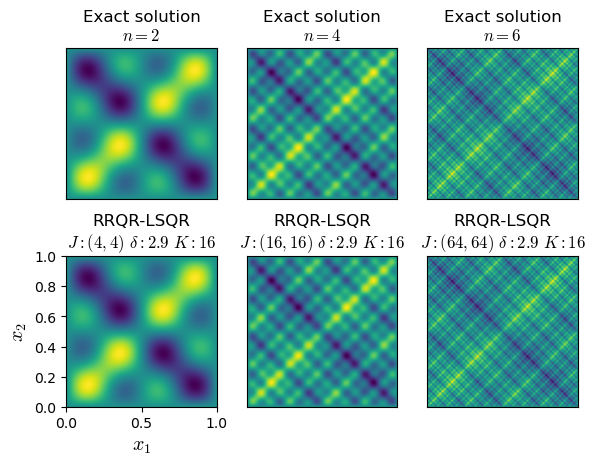

In [14]:
# WEAK SCALING COMPARISON

deltas = [dict(w0=v1, w=v2, m=v3, p=v4) for v1,v2,v3,v4 in [
        #(0, 2.9, 2, 16),# weak, m
        (1, 2.9, 4, 16),
        #(2, 2.9, 8, 16),
        (3, 2.9, 16, 16),
        #(4, 2.9, 32, 16),
        (5, 2.9, 64, 16),
]]
data = []
for config in apply_config_deltas(p0, deltas):
    (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
    sigma = config["sigma"]
    network = config["network"]
    h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
    w0,w,m = config["w0"], config["w"], config["m"]

    tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    problem=LaplaceELM2D_multiscale
    l=1
    n = (int(np.ceil(np.sqrt((p+1))))*m, int(np.ceil(np.sqrt((p+1))))*m)
    lr=1e-3
    
    c, model, i, t, l1n = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)

    # get exact solution
    c.n_test = (150,150)
    u_exact = exact_solution(c, model)
    u = FBPINN_solution(c, model)

    # get plot entry
    op_label, _ = optimiser_label(optimiser, optimiser_kwargs, run_fn)
    label = f"{op_label}\n$J:({m},{m})$ $\\delta:{w}$ $K:{p}$"

    data.append([w0, u_exact, u, label])


# plot

plt.figure(figsize=0.55*np.array([12,9]))

for i,(w0, u_exact, u, label) in enumerate(data):
    plt.subplot(2,3,1+i)
    plt.title(f"Exact solution\n$n={w0+1}$")
    im = plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
    fix_plot_2d_solution_blank()
    
    plt.subplot(2,3,1+3+i)
    plt.title(label)
    plt.imshow(u.T, origin="lower", extent=(0,1,0,1), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
    if i == 0: fix_plot_2d_solution()
    else: fix_plot_2d_solution_blank()

savefig(problem, "weak-solution")
plt.show()

Loading cached svals for M
Loading cached svals for Q


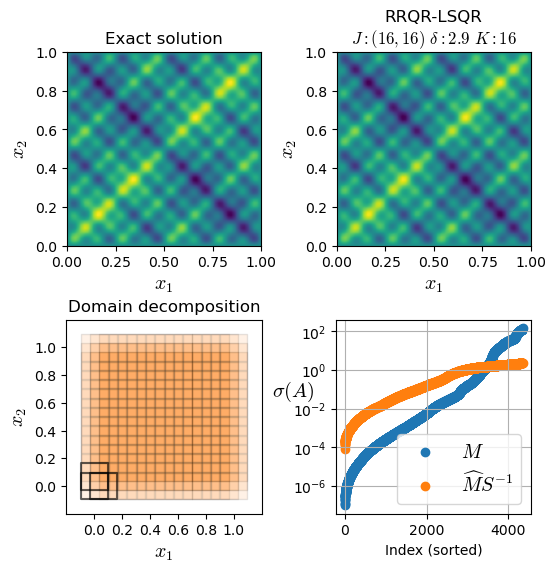

In [15]:
# BASE CASE PLOTS

(optimiser,optimiser_kwargs,run_fn) = p0["optimiser"]
sigma = p0["sigma"]
network = p0["network"]
h,p,weight_scale = p0["h"], p0["p"], p0["weight_scale"]
w0,w,m = p0["w0"], p0["w"], p0["m"]

tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
problem=LaplaceELM2D_multiscale
l=1
n = (int(np.ceil(np.sqrt((p+1))))*m, int(np.ceil(np.sqrt((p+1))))*m)
lr=1e-3

c, model, i, t, l1n = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)
op_label, _ = optimiser_label(optimiser, optimiser_kwargs, run_fn)
label = f"{op_label}\n$J:{(m,m)}$ $\\delta:{w}$ $K:{p}$"

# get exact solution
c.n_test = (150,150)
u_exact = exact_solution(c, model)
u = FBPINN_solution(c, model)

all_params = model[1]
domain = c.domain
xmin, xmax = all_params["static"]["domain"]["xmin"], all_params["static"]["domain"]["xmax"]
xmins, xmaxs, wmins, wmaxs, *_ = all_params["static"]["decomposition"]["subdomain"]["params"]
x_batch_ = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=n)


# plot solution vs exact, domain decomposition, spectra

plt.figure(figsize=0.6*np.array([10,10]))

plt.subplot(2,2,1)
plt.title("Exact solution")
im = plt.imshow(u_exact.T, origin="lower", extent=(0,1,0,1))
fix_plot_2d_solution()

plt.subplot(2,2,2)
plt.title(label)
plt.imshow(u.T, origin="lower", extent=(0,1,0,1), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
fix_plot_2d_solution()
xticks, yticks = plt.xticks(), plt.yticks()

plt.subplot(2,2,3)
plt.title("Domain decomposition")
patches, rs = [], []
for i in range(len(xmins)):
    patches.append(mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                       xmaxs[i,0]-xmins[i,0],
                                       xmaxs[i,1]-xmins[i,1],
                                     ))
    if i in [0,1,16]:
        rs.append(mpatches.Rectangle((xmins[i,0],xmins[i,1]),
                                      xmaxs[i,0]-xmins[i,0],
                                      xmaxs[i,1]-xmins[i,1],
                                     ))
plt.gca().add_collection(mcoll.PatchCollection(patches,
                                               alpha=0.1,
                                               edgecolor="k",
                                               facecolor="tab:orange"))
plt.gca().add_collection(mcoll.PatchCollection(rs,
                                               facecolor="none",
                                               linewidth=1.5,
                                               alpha=0.6,
                                               edgecolor="k"))
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.xticks(*xticks)
plt.yticks(*yticks)
plt.xlabel("$x_1$", fontsize="x-large"); plt.ylabel("$x_2$", fontsize="x-large")

plt.subplot(2,2,4)
plot_svd([cn(rootdir, c, "M"),cn(rootdir, c, "Q")], 
         ["$M$","$\\widehat{M} S^{-1}$"],
         labelpad=2)
plt.gca().yaxis.set_label_coords(-0.22, 0.57)

plt.subplots_adjust(wspace=0.38, hspace=0.38)

savefig(problem, "solution-condition")
plt.show()

# 2+1D Wave equation

In [16]:
depths = [(3, 8), (5, 8)]
p0 = dict(
    optimiser=optimisers[-1],
    sigma=1e-8,
    network=ELM,
    h=1,
    p=8,
    weight_scale=1,
    w0=0.2,
    w=2.9,
    m=8,
    )

In [17]:
# TABLES

deltas = (
    [dict(optimiser=v) for v in optimisers] +
    [dict(sigma=v) for v in sigmas] +
    [dict(network=v) for v in networks] +
    [dict(h=v1, p=v2) for v1,v2 in depths] +
    [dict(w=v) for v in overlaps]
)
rows = []
for config in apply_config_deltas(p0, deltas):
    (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
    sigma = config["sigma"]
    network = config["network"]
    h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
    w0,w,m = config["w0"], config["w"], config["m"]

    if run_fn == run_ELMFBPINN:
        problem=WaveEquationConstantVelocityELM3D
    else:
        problem=WaveEquationConstantVelocity3D
    l = 1
    n = (int(np.ceil(np.pow((p+1),1/3)))*m,
         int(np.ceil(np.pow((p+1),1/3)))*m,
         int(np.ceil(np.pow((p+1),1/3)))*m)
    if run_fn != run_ELMFBPINN:
        network = FCN
    if run_fn == run_PINN:
        h,p = 2, 128
    lr = 1e-3
    if run_fn == run_ELMFBPINN:
        tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    else:
        tag = f"main-{w0}-w0_{m}-m"
    
    # load models
    try:
        c, model, i, ts, l1s = loader[run_fn](tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)
    except Exception as e:
        print(tc(e, "red"))
        continue
        
    # get condition number
    if run_fn == run_ELMFBPINN:
        # load save_results run
        _c, *_ = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)
        info = load_npz(f"{rootdir}summaries/{_c.run}/info.npz")
        Mcn = f"{cn(rootdir, _c, "M")[0]:.1e}"
        if optimiser_kwargs["system"]=="normal":
            Acn = f"{cn(rootdir, _c, "A")[0]:.1e}"
        else:
            Acn = "N/A"
        if optimiser == BlockRRQRLinearSolver:
            Qcn = f"{cn(rootdir, _c, "Q")[0]:.1e}"
            drop_pct = f"{info[2]*100:.0f}\\%"
            Mrcn = f"{cn(rootdir, _c, "M_reduced")[0]:.1e}"
        else:
            Qcn = "N/A"
            drop_pct = "N/A"
            Mrcn = "N/A"
        if optimiser == AdditiveSchwarzLinearSolver:
            Pcn = f"{cn(rootdir, _c, "Ainv A")[0]:.1e}"
        else:
            Pcn = "N/A"
    else:
        Mcn = Acn = Qcn = Mrcn = Pcn = drop_pct = "N/A"
    
    # get other entries
    sigma = f"{sigma:.0e}" if optimiser == BlockRRQRLinearSolver else "N/A"
    op_label,_ = optimiser_label(optimiser, optimiser_kwargs, run_fn)
    loss = compact_sci(l1s[-3], l1s[-1]-l1s[-2])# min median +/- sd
    t = compact_sci(ts[0][-1], ts[1][-1])# mean +/- sd
    
    rows.append([network_label(network), (h,p), w,
                 Mcn, Mrcn, Qcn, Acn, Pcn,
                 op_label, f"{sigma} ({drop_pct})", loss, t])

columns = ["Network", "$(h,K)$", "$\\delta$",
           "$\\kappa(M)$", "$\\kappa(\\widehat{M})$", "$\\kappa(\\widehat{M} S^{-1})$", "$\\kappa(M^T M)$", "$\\kappa(A^{-1}_{AS} A)$", 
           "Optimiser", "$\\sigma$ ($\\phi_{jk}$ drop \\%)", "$e_{L_1}$", "Time (s)"]

s = make_latex_tabular(columns, rows)
savetex(s, problem, "table")
print(s)
make_latex_array(columns, rows)

10000.0 (3, 5) PINN_main-0.2-w0_8-m_WaveEquationConstantVelocity3D_FCN_2-layers_128-hidden_24-n_0.001-lr-4
10000.0 (3, 5) FBPINN_main-0.2-w0_8-m_WaveEquationConstantVelocity3D_FCN_1-levels_2.9-overlap_1-layers_8-hidden_24-n_0.001-lr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_LinearSolver-least-squares-sps_lsqr-4
Loading cached svals for M
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_LinearSolver-normal-sps_cg-4
Loading cached svals for M
Loading cached svals for A
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
Loading cached svals for M
Loading cached svals for A
Loading cached svals for Ainv A
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_W

<IPython.core.display.Latex object>

10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_LinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4


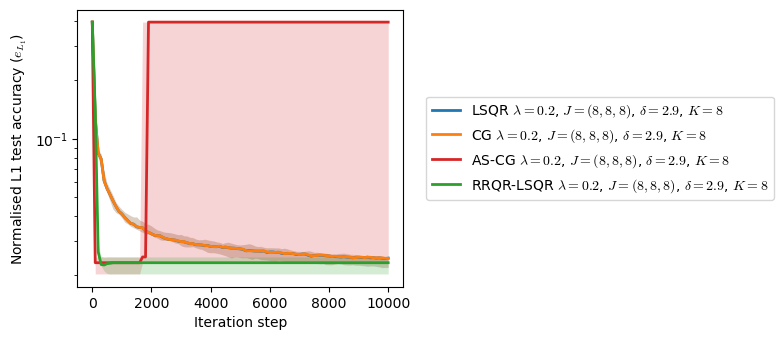

In [18]:
# CONVERGENCE TEST LOSS vs STEP

deltas = (
    [dict(optimiser=v) for v in optimisers[2:]]
)
data = []
for config in apply_config_deltas(p0, deltas):
    (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
    sigma = config["sigma"]
    network = config["network"]
    h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
    w0,w,m = config["w0"], config["w"], config["m"]

    if run_fn == run_ELMFBPINN:
        problem=WaveEquationConstantVelocityELM3D
    else:
        problem=WaveEquationConstantVelocity3D
    l = 1
    n = (int(np.ceil(np.pow((p+1),1/3)))*m,
         int(np.ceil(np.pow((p+1),1/3)))*m,
         int(np.ceil(np.pow((p+1),1/3)))*m)
    if run_fn != run_ELMFBPINN:
        network = FCN
    if run_fn == run_PINN:
        h,p = 2, 128
    lr = 1e-3
    if run_fn == run_ELMFBPINN:
        tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    else:
        tag = f"main-{w0}-w0_{m}-m"

    # load models
    c, model, i, ts, l1s = load_ELMFBPINN_info(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)

    # get plot entry
    op_label, icolor = optimiser_label(optimiser, optimiser_kwargs, run_fn)
    label = f"{op_label} $\\lambda={w0}$, $J={(m,m,m)}$, $\\delta={w}$, $K={p}$"
    data.append((label, icolor, i, ts, l1s))

plt.figure(figsize=0.6*np.array([7,6]))
for r, (label, icolor, i, ts, l1s) in enumerate(data):
    plot_l1(i, l1s, label=label, marker=None, color=colors[icolor], s=100, lw=2)
fix_plot_convergence(legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
savefig(problem, "convergence")
plt.show()

10000.0 (101, 5) ELMFBPINN_main-0.2-w0_4-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_1.45-overlap_1-layers_8-hidden_12-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_16-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_5.8-overlap_1-layers_8-hidden_48-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_4-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_1.45-overlap_1-layers_8-hidden_12-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
Model dir empty for run ELMFBPINN_main-0.2-w0_16-m_sigma-1e-08_ws-1_WaveEquationConst

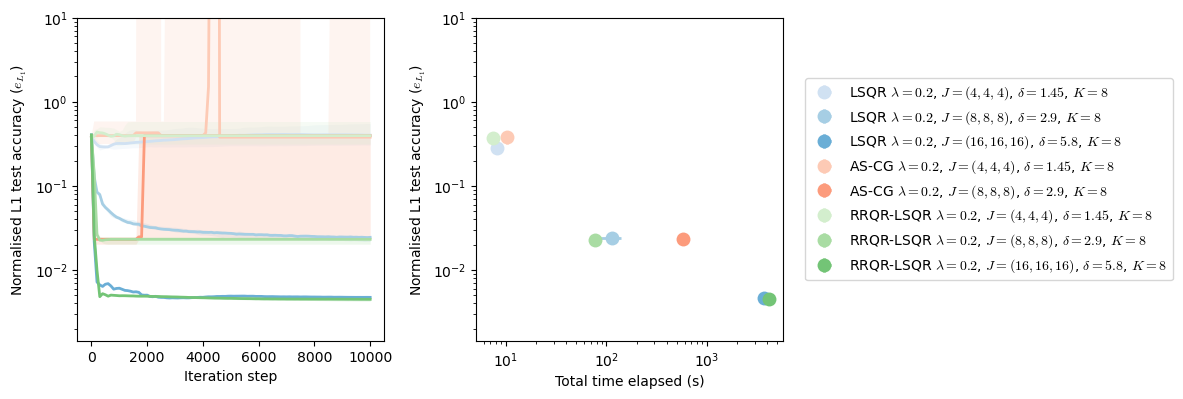

10000.0 (101, 5) ELMFBPINN_main-0.2-w0_4-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_12-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_16-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_48-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_4-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_12-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
Model dir empty for run ELMFBPINN_main-0.2-w0_16-m_sigma-1e-08_ws-1_WaveEquationConstan

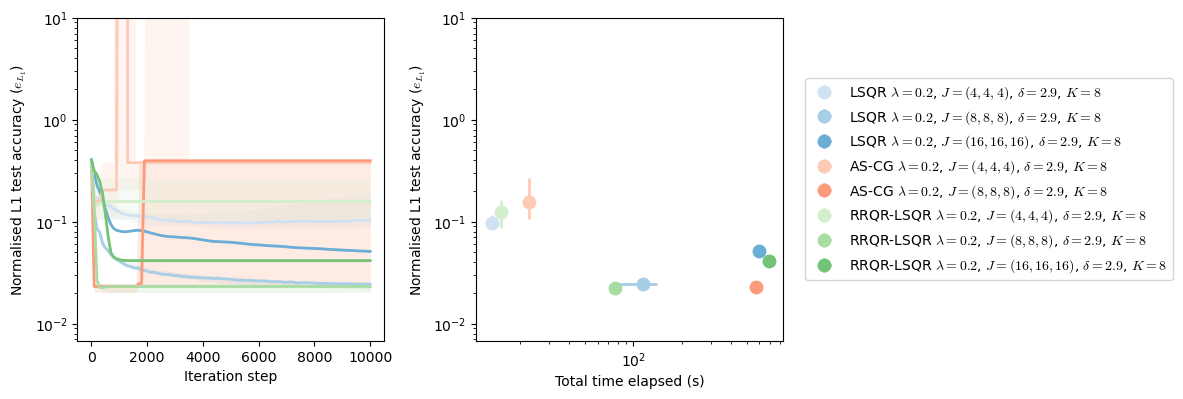

10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_4-hidden_16-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_16-hidden_24-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_32-hidden_32-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_4-hidden_16-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3

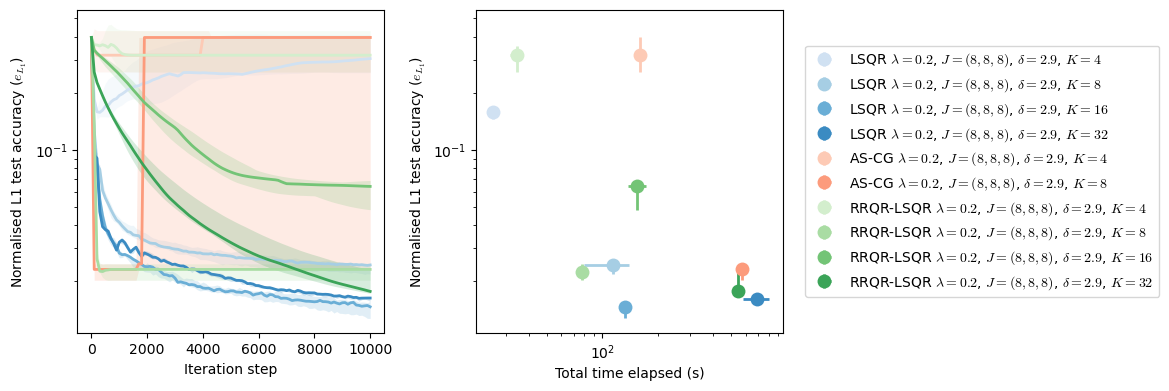

10000.0 (101, 5) ELMFBPINN_main-0.4-w0_4-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_12-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.1-w0_16-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_48-n_LinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-0.4-w0_4-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_12-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
10000.0 (101, 5) ELMFBPINN_main-0.2-w0_8-m_sigma-1e-08_ws-1_WaveEquationConstantVelocityELM3D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_24-n_AdditiveSchwarzLinearSolver-normal-sps_cg-4
Model dir empty for run ELMFBPINN_main-0.1-w0_16-m_sigma-1e-08_ws-1_WaveEquationConstan

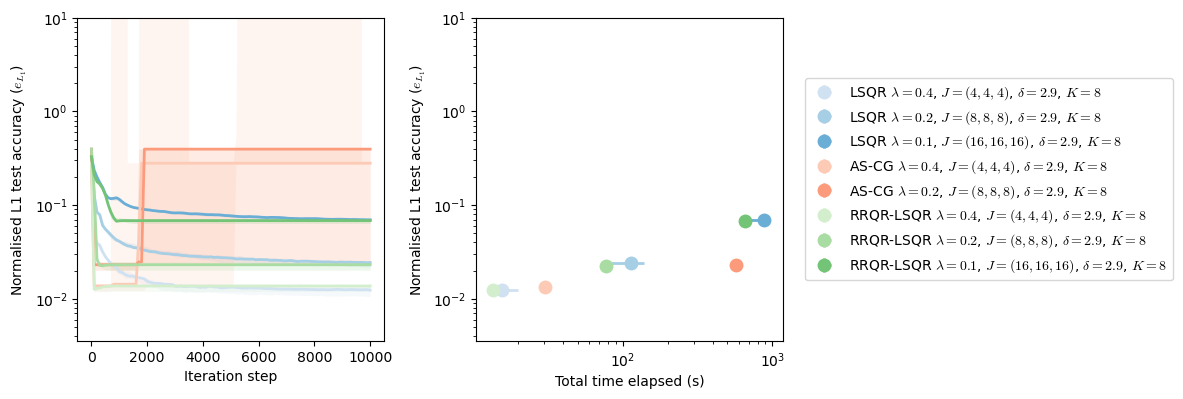

In [19]:
# FINAL TEST LOSS vs TIME (scaling)


# accuracy vs time [w0,overlap,dd,optimiser] (strong scaling & weak scaling) (weak scaling has solution plot from our solver)

for iw_deltas,tag2 in zip(
(
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (0.2, 2.9*0.5, 4, 8),# strong, w-m
        (0.2, 2.9*1, 8, 8),
        (0.2, 2.9*2, 16, 8),
       ])]
    ),
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (0.2, 2.9, 4, 8),# strong, m
        (0.2, 2.9, 8, 8),
        (0.2, 2.9, 16, 8),
       ])]
    ),
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (0.2, 2.9, 8, 4),# strong, p
        (0.2, 2.9, 8, 8),
        (0.2, 2.9, 8, 16),
        (0.2, 2.9, 8, 32),
       ])]
    ),
    (
    [(iw, dict(w0=v1, w=v2, m=v3, p=v4, optimiser=v5)) for v5 in [optimisers[i] for i in [-4,-2,-1]] for iw,(v1,v2,v3,v4) in enumerate([
        (0.4, 2.9, 4, 8),# weak, m
        (0.2, 2.9, 8, 8),
        (0.1, 2.9, 16, 8),
       ])]
    ),
),
    ["strong-wm", "strong-m", "strong-p", "weak"]):
    
    iws, deltas = zip(*iw_deltas)
    data = []
    for iw,config in zip(iws, apply_config_deltas(p0, deltas)):
        (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
        sigma = config["sigma"]
        network = config["network"]
        h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
        w0,w,m = config["w0"], config["w"], config["m"]
    
        if run_fn == run_ELMFBPINN:
            problem=WaveEquationConstantVelocityELM3D
        else:
            problem=WaveEquationConstantVelocity3D
        l = 1
        n = (int(np.ceil(np.pow((p+1),1/3)))*m,
             int(np.ceil(np.pow((p+1),1/3)))*m,
             int(np.ceil(np.pow((p+1),1/3)))*m)
        if run_fn != run_ELMFBPINN:
            network = FCN
        if run_fn == run_PINN:
            h,p = 2, 128
        lr = 1e-3
        if run_fn == run_ELMFBPINN:
            tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
        else:
            tag = f"main-{w0}-w0_{m}-m"
    
        # load models
        try:
            c, model, i, ts, l1s = load_ELMFBPINN_info(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)
        except Exception as e:
            print(tc(e, "red"))
            continue
            
        # get plot entry
        op_label, icolor = optimiser_label(optimiser, optimiser_kwargs, run_fn)
        label = f"{op_label} $\\lambda={w0}$, $J={(m,m,m)}$, $\\delta={w}$, $K={p}$"
        data.append((label, icolor, iw, i, ts, l1s))
    
    
    plt.figure(figsize=0.7*np.array([13,6]))
    
    plt.subplot(1,2,1)
    for label, icolor, iw, i, ts, l1s in data:
        plot_l1(i, l1s, label=label, marker=None, color=colorss[icolor][iw], s=100, lw=2)
    fix_plot_convergence(legend=False)
    ylim = plt.ylim()
    mi = min([d[5][2].min() for d in data])# min l1n mi
    ylim=(max(mi/3,ylim[0]),min(ylim[1], 1e1))
    plt.ylim(ylim)
    
    plt.subplot(1,2,2)
    for label, icolor, iw, i, ts, l1s in data:
        scatter_l1(ts, l1s, label=label, marker="o", color=colorss[icolor][iw], s=10, lw=2)
    fix_plot_scaling()
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    plt.ylim(ylim)
    
    plt.subplots_adjust(wspace=0.3)
    savefig(problem, f"{tag2}-scaling")
    plt.show()

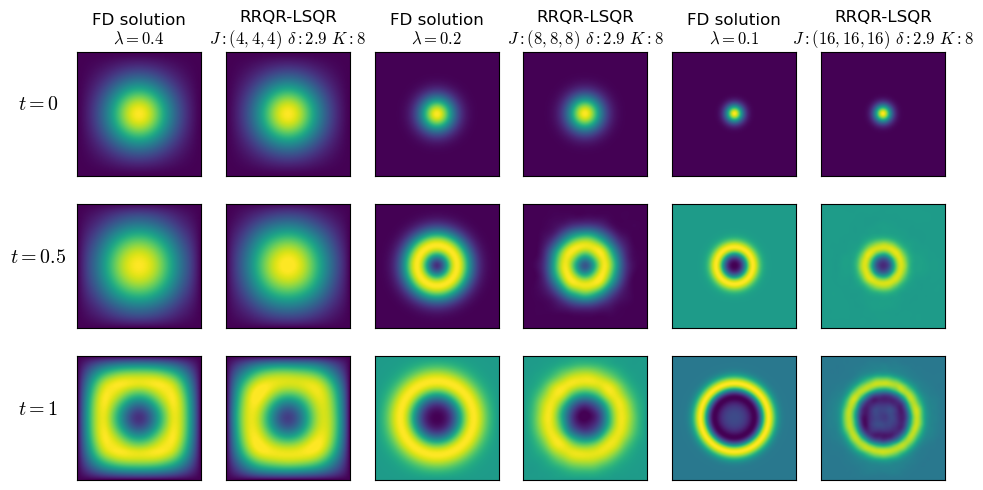

In [20]:
# WEAK SCALING COMPARISON

deltas = [dict(w0=v1, w=v2, m=v3, p=v4) for v1,v2,v3,v4 in [
        (0.4, 2.9, 4, 8),# weak, m
        (0.2, 2.9, 8, 8),
        (0.1, 2.9, 16, 8),
]]
data = []
for config in apply_config_deltas(p0, deltas):
    (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
    sigma = config["sigma"]
    network = config["network"]
    h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
    w0,w,m = config["w0"], config["w"], config["m"]

    tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
    problem=WaveEquationConstantVelocityELM3D
    l=1
    n = (int(np.ceil(np.pow((p+1),1/3)))*m,
         int(np.ceil(np.pow((p+1),1/3)))*m,
         int(np.ceil(np.pow((p+1),1/3)))*m)
    lr=1e-3
    
    c, model, i, t, l1n = load_ELMFBPINN_(tag, problem, network, l, w, h, p, n, lr, seed, optimiser, optimiser_kwargs, rootdir)

    # get exact solution
    c.n_test = (150,150,3)
    u_exact = exact_solution(c, model)
    u = FBPINN_solution(c, model)

    # get plot entry
    op_label, _ = optimiser_label(optimiser, optimiser_kwargs, run_fn)
    label = f"{op_label}\n$J:({m},{m},{m})$ $\\delta:{w}$ $K:{p}$"

    data.append([w0, u_exact, u, label])


# plot

plt.figure(figsize=0.7*np.array([16,8]))

for ie,(w0, u_exact, u, label) in enumerate(data):
    for i in range(3):
        plt.subplot(3,6,1 +2*ie + 6*i)
        if i == 0: plt.title(f"FD solution\n$\\lambda={w0}$")
        im = plt.imshow(u_exact[:,:,i].T, origin="lower", extent=(0,1,0,1))
        fix_plot_2d_solution_blank()
        if ie == 0:
            plt.ylabel(f"$t={[0,0.5,1][i]}$", fontsize="x-large", rotation=0, labelpad=28)
    
        plt.subplot(3,6,1 +2*ie+1 + 6*i)
        if i == 0: plt.title(label)
        plt.imshow(u[:,:,i].T, origin="lower", extent=(0,1,0,1), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
        fix_plot_2d_solution_blank()

savefig(problem, "weak-solution")
plt.show()

# Weight scaling (across all problems)

10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-0.125_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-0.125_HarmonicOscillatorELM1D_ELM_sigmoid_1-levels_2.9-overlap_1-layers_8-hidden_180-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-0.125_HarmonicOscillatorELM1D_ELM_SIREN_1-levels_2.9-overlap_1-layers_8-hidden_180-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-0.25_HarmonicOscillatorELM1D_ELM_1-levels_2.9-overlap_1-layers_8-hidden_180-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-0.25_HarmonicOscillatorELM1D_ELM_sigmoid_1-levels_2.9-overlap_1-layers_8-hidden_180-n_BlockRRQRLinearSolver-least-squares-sps_lsqr-4
10000.0 (101, 5) ELMFBPINN_main-60-w0_20-m_sigma-1e-08_ws-0.

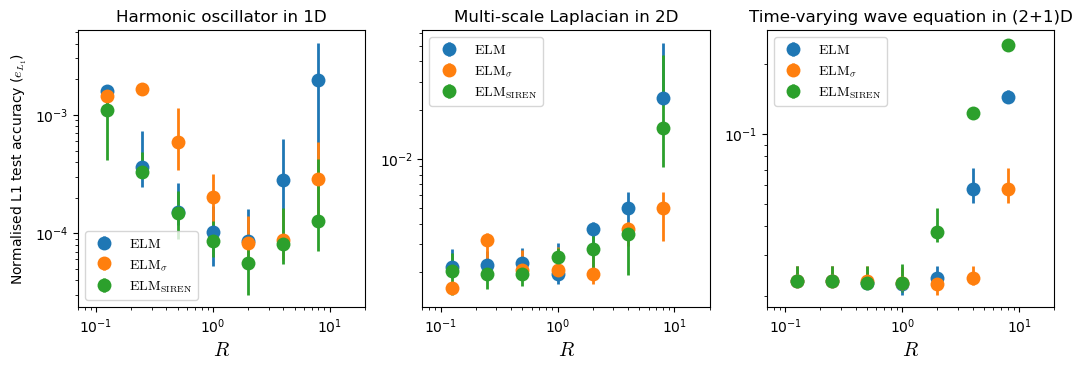

In [21]:
# WEIGHT SCALING COMPARISON

networks_ = [ELM, ELM_sigmoid, ELM_SIREN]
deltas = [dict(weight_scale=v1, network=v2) for v1 in weight_scales for v2 in networks_]

datas = []
for ip,(p0, problem) in enumerate(zip([
dict(
    optimiser=optimisers[-1],
    sigma=1e-8,
    network=ELM,
    h=1,
    p=8,
    weight_scale=1,
    w0=60,
    w=2.9,
    m=20,
    ),
dict(
    optimiser=optimisers[-1],
    sigma=1e-8,
    network=ELM,
    h=1,
    p=16,
    weight_scale=1,
    w0=3,
    w=2.9,
    m=16,# m = omegas
    ),
dict(
    optimiser=optimisers[-1],
    sigma=1e-8,
    network=ELM,
    h=1,
    p=8,
    weight_scale=1,
    w0=0.2,
    w=2.9,
    m=8,
    ),
],
[
HarmonicOscillatorELM1D,
LaplaceELM2D_multiscale,
WaveEquationConstantVelocityELM3D,
])):
    data = []
    for config in apply_config_deltas(p0, deltas):
        (optimiser,optimiser_kwargs,run_fn) = config["optimiser"]
        sigma = config["sigma"]
        network = config["network"]
        h,p,weight_scale = config["h"], config["p"], config["weight_scale"]
        w0,w,m = config["w0"], config["w"], config["m"]
    
        tag = f"main-{w0}-w0_{m}-m_sigma-{sigma}_ws-{weight_scale}"
        l=1
        lr=1e-3
        if problem is HarmonicOscillatorELM1D:
            n = ((p+1)*m,)
        elif problem is LaplaceELM2D_multiscale:
            n = (int(np.ceil(np.sqrt((p+1))))*m, int(np.ceil(np.sqrt((p+1))))*m)
        elif problem is WaveEquationConstantVelocityELM3D:
            n = (int(np.ceil(np.pow((p+1),1/3)))*m,
             int(np.ceil(np.pow((p+1),1/3)))*m,
             int(np.ceil(np.pow((p+1),1/3)))*m)
        
        # load models
        try:
            c, model, i, ts, l1s = load_ELMFBPINN_info(tag, problem, network, l, w, h, p, n, lr, n_seeds, optimiser, optimiser_kwargs, rootdir)
        except Exception as e:
            print(tc(e, "red"))
            continue
        
        # get plot entry
        label = network_label(network) if weight_scale == 1 else None
        color = colors[{k:i for i,k in enumerate(networks_)}[network]]
        data.append([problem_label(problem), weight_scale, l1s[-3:], color, label])
    datas.append(data)


# plot

plt.figure(figsize=0.6*np.array([3*7,6]))
for ip,data in enumerate(datas):
    plt.subplot(1,3,ip+1)
    for i,(title, weight_scale, (l1_min_me, l1_min_mi, l1_min_ma), color, label) in enumerate(data):
        plt.errorbar(weight_scale, l1_min_me, 
                     yerr=np.array([[l1_min_me-l1_min_mi],[l1_min_ma-l1_min_me]]),
                     ecolor=color,
                     marker="o",
                     markeredgecolor="none",
                     markerfacecolor=color,
                     label=label,
                     markersize=10,
                     lw=0,
                     elinewidth=2)
    plt.xlabel("$R$", fontsize="x-large")
    if ip == 0: plt.ylabel("Normalised L1 test accuracy ($e_{L_1}$)")
    plt.legend()
    plt.title(title)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim(7e-2, 2e1)
savefig(problem, "weight-scaling")
plt.show()